<a href="https://colab.research.google.com/github/dyfzl/AI-JBNU/blob/main/%EC%9E%91%EA%B0%80%EC%9D%98%20%EB%AC%B8%EC%B2%B4%EB%A5%BC%20%ED%95%99%EC%8A%B5%ED%95%9C%20%EB%AA%A8%EB%8D%B8%EC%9D%98%20%ED%85%8D%EC%8A%A4%ED%8A%B8%20%EC%83%9D%EC%84%B1%20%EB%B0%8F%20%EA%B0%90%EC%84%B1%20%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#!pip install datasets

In [8]:
import os

# WandB 비활성화
os.environ["WANDB_DISABLED"] = "true"


In [6]:
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive/')

# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/소설작가분류/train.csv')
test = pd.read_csv('/content/drive/MyDrive/소설작가분류/test_x.csv')


Mounted at /content/drive/


In [9]:
# 데이터 확인
df = train
author_counts = df['author'].value_counts()
print(author_counts)

# 특정 작가(author=3)의 데이터 필터링 및 전처리
import re
def clean_text_preserve_style(text):
    text = re.sub(r"[^\w\s.,!?']", "", text)  # 특수문자 중 쉼표, 마침표 등 유지
    text = re.sub(r"\s+", " ", text).strip()  # 불필요한 공백 제거
    return text

author_data = df[df['author'] == 3]
author_data["text"] = author_data["text"].apply(clean_text_preserve_style)


author
3    15063
0    13235
2    11554
4     7805
1     7222
Name: count, dtype: int64


<ipython-input-9-6f4169ac472e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data["text"] = author_data["text"].apply(clean_text_preserve_style)


In [10]:

# Hugging Face 모델 준비 (GPT-2)
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Padding token 추가
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(50257, 768)

In [11]:

# 데이터셋 준비 및 전처리
from sklearn.model_selection import train_test_split
from datasets import Dataset

train_data, eval_data = train_test_split(author_data, test_size=0.1, random_state=42)
train_dataset = Dataset.from_pandas(train_data[["text"]])
eval_dataset = Dataset.from_pandas(eval_data[["text"]])

def preprocess_data_with_labels(examples):
    inputs = tokenizer(
        examples["text"], max_length=512, truncation=True, padding="max_length"
    )
    inputs["labels"] = inputs["input_ids"]
    return inputs

train_dataset = train_dataset.map(preprocess_data_with_labels, batched=True)
eval_dataset = eval_dataset.map(preprocess_data_with_labels, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/13556 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

In [12]:
from transformers import Trainer, TrainingArguments, GPT2Tokenizer, GPT2LMHeadModel

# Trainer 설정 및 학습
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=1000,
    evaluation_strategy="steps",
    eval_steps=1000,
    logging_dir="./logs",
    logging_steps=500,
    learning_rate=3e-5,
    warmup_steps=100,
    weight_decay=0.01,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

# 모델 학습
trainer.train()

# 모델과 토크나이저 저장
save_directory = "/content/fine_tuned_model"
trainer.save_model(save_directory)  # 학습된 모델 저장
tokenizer.save_pretrained(save_directory)  # 토크나이저 저장

print(f"Model and tokenizer saved to {save_directory}")

# 모델과 토크나이저 다시 불러오기
tokenizer = GPT2Tokenizer.from_pretrained(save_directory)
model = GPT2LMHeadModel.from_pretrained(save_directory)

print("Model and tokenizer loaded successfully!")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-4cdb61ba03b6>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
1000,0.368100,0.345895
2000,0.346000,0.339348
3000,0.345300,0.334837
4000,0.332700,0.333570
5000,0.339600,0.332399


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model and tokenizer saved to /content/fine_tuned_model
Model and tokenizer loaded successfully!


In [13]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# 저장된 경로 지정
save_directory = "./fine_tuned_model"

# 모델과 토크나이저 불러오기
tokenizer = GPT2Tokenizer.from_pretrained(save_directory)
model = GPT2LMHeadModel.from_pretrained(save_directory)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [20]:
# 텍스트 생성
from transformers import pipeline

# 텍스트 생성 파이프라인 설정
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# 테스트 프롬프트 정의
test_prompts = ["We", "The day was bright", "she"]

# 텍스트 생성 및 저장
generated_texts = [
    text_generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
    for prompt in test_prompts
]

# 생성된 텍스트 출력
print("Generated Texts:")
for i, (prompt, generated) in enumerate(zip(test_prompts, generated_texts)):
    print(f"\nPrompt {i + 1}: {prompt}")
    print(f"Generated Text {i + 1}: {generated}")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Generated Texts:

Prompt 1: We
Generated Text 1: We will be there, the princes elder repeated as he reached the door.

Prompt 2: The day was bright
Generated Text 2: The day was brightand in the evening it was dark. The prince would have expected no light from the candle but odin was still asleep. He did not know why he was sleeping. He was afraid of the dark and he had no clothes, so he did not carry much. But as soon as the candle lighted, the bedfellows had come. odin waited on him with a soft smile, and when he had gone out of the cell he was in bed with the prince,

Prompt 3: she
Generated Text 3: she went up to him, and gave him the most unexpected answer, but only to a sort of surprise. He had thought in his brain nothing about the question the question asked himself.


In [34]:
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd

# 감정 분석 모델 설정
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# 유사 문장 찾기: 상위 8000개의 참조 문장을 비교
def find_related_sentences(prompts, data, top_n=8000):
    all_sentences = data['text'].tolist()
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(all_sentences)

    related_sentences = []
    for prompt in prompts:
        prompt_vector = vectorizer.transform([prompt])
        similarities = cosine_similarity(prompt_vector, sentence_vectors).flatten()
        top_indices = similarities.argsort()[-top_n:][::-1]
        top_related = [all_sentences[i] for i in top_indices]
        related_sentences.append(top_related)
    return related_sentences

# BLEU 점수 계산 함수
def calculate_bleu_with_multiple_references(generated, references):
    bleu_scores = []
    smoothing = SmoothingFunction().method1
    for gen_text, ref_texts in zip(generated, references):
        ref_tokens = [ref.split() for ref in ref_texts]  # 참조 문장 토큰화
        gen_tokens = gen_text.split()  # 생성된 텍스트 토큰화
        bleu_score = sentence_bleu(ref_tokens, gen_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
        bleu_scores.append(bleu_score)
    return bleu_scores

# 감정 분석 함수
def analyze_sentiments(texts):
    sentiment_mapping = {
        "POSITIVE": "Positive",
        "NEGATIVE": "Negative",
        "NEUTRAL": "Neutral"
    }
    sentiments = []
    for text in texts:
        sentiment = sentiment_analyzer(text)
        label = sentiment[0]['label']
        sentiments.append(sentiment_mapping.get(label, "Unknown"))
    return sentiments

# 테스트 프롬프트
test_prompts = ["We", "The day was bright", "she"]

# 텍스트 생성
generated_texts = [
    text_generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
    for prompt in test_prompts
]

# 참조 문장 선택 (상위 8000개)
top_n = 8000
similar_sentences = find_related_sentences(test_prompts, eval_data, top_n)

# BLEU 점수 계산
bleu_scores = calculate_bleu_with_multiple_references(generated_texts, similar_sentences)

# 감정 분석 수행
generated_sentiments = analyze_sentiments(generated_texts)

# 상위 5개 참조 문장만 출력하도록 설정
top_5_sentences = [["\n".join(sentences[:5])] for sentences in similar_sentences]

# 결과 데이터프레임 생성
results_df = pd.DataFrame({
    "Prompt": test_prompts,
    "Generated Text": generated_texts,
    "Sentiment": generated_sentiments,
    "BLEU Score": bleu_scores,
    "Top Similar Sentences (Top 5)": [sentences[0] for sentences in top_5_sentences]
})

# 결과 출력
def display_results_with_sentiments(df):
    for index, row in df.iterrows():
        print(f"\n--- Prompt {index + 1} ---")
        print(f"Prompt: {row['Prompt']}")
        print(f"Generated Text: {row['Generated Text']}")
        print(f"Sentiment: {row['Sentiment']}")
        print(f"BLEU Score: {row['BLEU Score']:.4f}")
        print("Top 5 Similar Sentences:")
        print(row["Top Similar Sentences (Top 5)"])
        print("-" * 50)

# BLEU 점수와 감정 분석 결과 출력
display_results_with_sentiments(results_df)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



--- Prompt 1 ---
Prompt: We
Generated Text: We've never met before, odin began, almost as though he had just seen odin there but he had not expected the fact.
Sentiment: Positive
BLEU Score: 0.3665
Top 5 Similar Sentences:
No, no we all want it.
I was standing at the gate with them... dont you remember? We have carried on our trade in that house for years past. We cure and prepare hides, we take work home... most of all I was vexed....
You think we may become friends?
I believe we can say _goodbye_!
You shall have some, too, when we get home.
--------------------------------------------------

--- Prompt 2 ---
Prompt: The day was bright
Generated Text: The day was bright and early, but it was dark and the snow was covering the country. Three days later the snow had not yet risen, but the general walked over to the gate, stood in the snow in an ice chair, and began to go about the streets. In the evening he met some strange visitor. And on entering the gate he was greeted with a loud b

In [24]:
# 결과 데이터프레임 생성
results_df = pd.DataFrame({
    "Prompt": test_prompts,
    "Generated Text": generated_texts,
    "Reference Texts": [", ".join(reference_texts)] * len(test_prompts),
    "Sentiment": generated_sentiments,
    "BLEU Score": bleu_scores,
})

# 결과 출력
print("Generated Text Analysis Results:")
print(results_df)

# 분석 함수 정의
def analyze_results(df):
    for index, row in df.iterrows():
        print(f"\n--- Analysis for Prompt {index + 1} ---")
        print(f"Prompt: {row['Prompt']}")
        print(f"Generated Text: {row['Generated Text']}")
        print(f"Reference Texts: {row['Reference Texts'][:10]}...")  # 참조 텍스트 일부만 출력
        print(f"Sentiment: {row['Sentiment']}")
        print(f"BLEU Score: {row['BLEU Score']:.6f}")

        # BLEU 점수 평가
        if row["BLEU Score"] > 0.05:
            print("Analysis: The generated text is fairly similar to the reference texts.")
        elif row["BLEU Score"] > 0.02:
            print("Analysis: The generated text has some similarity to the reference texts.")
        else:
            print("Analysis: The generated text is quite different from the reference texts.")

        # 감정 분석 평가
        if row["Sentiment"] == "Positive":
            print("Sentiment Analysis: The generated text conveys a positive sentiment.")
        elif row["Sentiment"] == "Negative":
            print("Sentiment Analysis: The generated text conveys a negative sentiment.")
        elif row["Sentiment"] == "Neutral":
            print("Sentiment Analysis: The generated text conveys a neutral sentiment.")
        else:
            print("Sentiment Analysis: Unable to determine the sentiment.")

# 결과 분석 실행
analyze_results(results_df)


Generated Text Analysis Results:
               Prompt                                     Generated Text  \
0                  We  We will be there, the princes elder repeated a...   
1  The day was bright  The day was brightand in the evening it was da...   
2                 she  she went up to him, and gave him the most unex...   

                                     Reference Texts Sentiment  BLEU Score  
0  He was in terrible haste, he snatched the keys...  Positive    0.043242  
1  He was in terrible haste, he snatched the keys...  Positive    0.016498  
2  He was in terrible haste, he snatched the keys...  Positive    0.011470  

--- Analysis for Prompt 1 ---
Prompt: We
Generated Text: We will be there, the princes elder repeated as he reached the door.
Reference Texts: He was in terrible haste, he snatched the keys, and began trying them again. But he was unsuccessful. They would not fit in the locks. It was not so much that his hands were shaking, but that he kept making mis


--- Prompt 1 ---
Prompt: We
Generated Text: We've never met before, odin began, almost as though he had just seen odin there but he had not expected the fact.
Sentiment: Positive
BLEU Score: 0.3665
Top 5 Similar Sentences:
No, no we all want it.
I was standing at the gate with them... dont you remember? We have carried on our trade in that house for years past. We cure and prepare hides, we take work home... most of all I was vexed....
You think we may become friends?
I believe we can say _goodbye_!
You shall have some, too, when we get home.
--------------------------------------------------

--- Prompt 2 ---
Prompt: The day was bright
Generated Text: The day was bright and early, but it was dark and the snow was covering the country. Three days later the snow had not yet risen, but the general walked over to the gate, stood in the snow in an ice chair, and began to go about the streets. In the evening he met some strange visitor. And on entering the gate he was greeted with a loud b

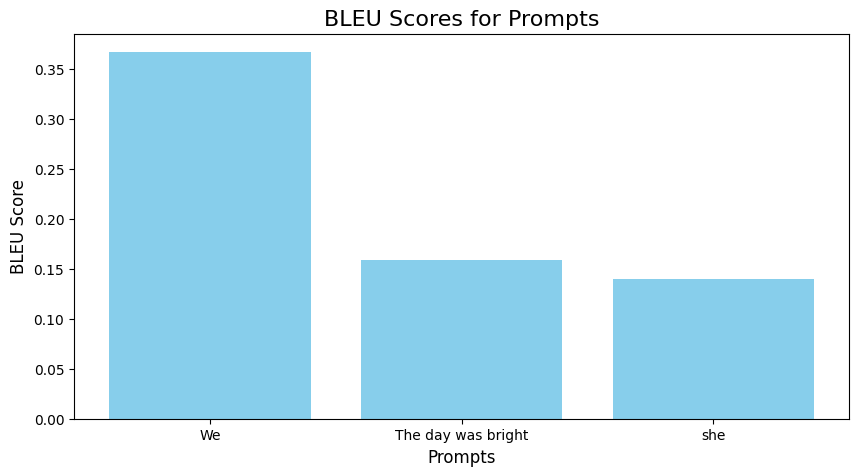

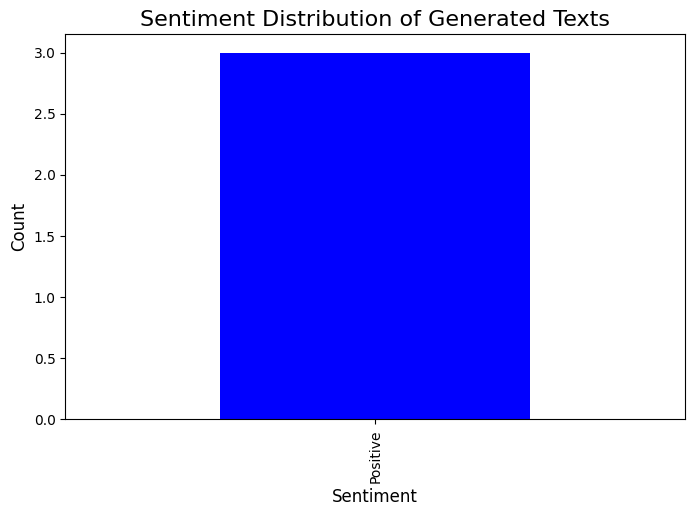

In [35]:
# 시각화 함수
def visualize_results(df):
    # BLEU 점수 시각화
    plt.figure(figsize=(10, 5))
    plt.bar(df["Prompt"], df["BLEU Score"], color="skyblue")
    plt.title("BLEU Scores for Prompts", fontsize=16)
    plt.xlabel("Prompts", fontsize=12)
    plt.ylabel("BLEU Score", fontsize=12)
    plt.show()

    # 감정 분석 분포 시각화
    sentiment_counts = df["Sentiment"].value_counts()
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind="bar", color=["blue", "orange", "green"])
    plt.title("Sentiment Distribution of Generated Texts", fontsize=16)
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.show()

# 결과 출력 함수
def display_results_with_sentiments(df):
    for index, row in df.iterrows():
        print(f"\n--- Prompt {index + 1} ---")
        print(f"Prompt: {row['Prompt']}")
        print(f"Generated Text: {row['Generated Text']}")
        print(f"Sentiment: {row['Sentiment']}")
        print(f"BLEU Score: {row['BLEU Score']:.4f}")
        print("Top 5 Similar Sentences:")
        print(row["Top Similar Sentences (Top 5)"])
        print("-" * 50)

# BLEU 점수와 관련 문장 출력
display_results_with_sentiments(results_df)

# 시각화 출력
visualize_results(results_df)